# MES - Morhpological Equal-area Segmentation

**main function: segment(** *video, fr, mask, n_ROIs_out=16, n_ROIs_in=16* **)**

Return ROIs masks, means from ROIs masks and time.

Divide cell mask into two major regions (inner and outter region), then divide these regions into smaller regions of interest (ROIs) with similar area following cell shape. The number of ROIs in each major region can be adjusted by *n_ROIs_out* and *n_ROIs_in* arguments. Also, get ROIs means over time from video.

**Parameters:**  
- **video: array**
    - (F x M x N) 16-bit gray image stack, where F are frames, M are lines and N are columns.
- **fr: int**
    - video frame rate (in frames per second).
- **mask: boolean array**
    - (M x N) boolean array. Must match video dimensions.
- **n_ROIs_out: int, optional**
    - number of ROIs in the outter region.
- **n_ROIs_in: int, optional**
    - number of ROIs in the inner region.
 
**Returns:**  
- **ROIs: boolean array**
    - (R x M x N) image stack, where R are ROI numbers (R = n_ROIs_in + n_ROIs_out), M are lines and N are columns.
- **ROIs_means: array**
    - (F x R) array, where F are frames and R are ROI numbers.
- **time: array**
    - (F,) array, where F are time points.


In [1]:
testing = (__name__ == "__main__")
if testing:
#     %matplotlib inline
    import matplotlib.pyplot as plt
    import matplotlib.image as mpimg
    import numpy as np
    import sys,os
    mespath = os.path.abspath('')
    if mespath not in sys.path:
        sys.path.append(mespath)

## Mandatory Parameters:

In [2]:
if testing:
    from skimage import io
    fpath = 'Data\\Cell2\\Videos_AP'
    fr = 55.78 #71.29
    fname = 'avid_1.tif'
    fullpath = fpath + '\\' + fname
    video = io.imread(fullpath)
    mname = 'cellmask.tif'
    fullpath = fpath + '\\' + mname
    mask = io.imread(fullpath)

## MES functions:

In [3]:
def build_time_vector(fr,video_shape):
    import numpy as np
    time = np.cumsum(np.ones(video_shape[0]))
    time = (time-1)/fr  
    return(time)

In [4]:
def create_inner_mask(mask,area_percent=0.5):
    import numpy as np
    import scipy.ndimage as sm
    structE = np.ones((3,3))

    mask_area = np.sum(mask>0)
    m_erosion = np.copy(mask)
    m_erosion_area = mask_area
    iterations = 0
    while(m_erosion_area>area_percent*mask_area):
        m_erosion = sm.binary_erosion(m_erosion,structure=structE)
        m_erosion_area = np.sum(m_erosion>0)
        iterations+=1
    if iterations%2==0:
        mask_in = m_erosion
    else:
        iterations-=1
        mask_in = sm.binary_dilation(m_erosion,structure=structE)


    contourmask = (mask.astype(int)-mask_in).astype(bool)

    return(mask_in,contourmask,iterations)

In [5]:
def standardize_angle(angle):
#     if angle==-180:
#         angle=0
#     if anlge==180:
#         angle=0
    if angle<=0:
        angle = angle+180
    elif angle>=180:
        angle = angle-180
    return(angle)

In [6]:
def get_angle(f):
    from skimage.measure import label, regionprops
    import numpy as np
    label_img = label(f)
    regions = regionprops(label_img)
    for props in regions:
        if props.area>200:
            orientation = props.orientation
            centroid = props.centroid
    angle = np.rad2deg(orientation)
#     print(angle)
    angle = standardize_angle(angle)
#     print(angle)
    return(angle,centroid)

In [7]:
def align_mask(mask,revert=False,theta=0,orig_shape=None):
    if revert==False:
        angle,centroid = get_angle(mask)
        theta = 90-angle
        mask_rot = rotate(mask,theta)
        return(mask_rot,angle)
    else:
        mask_rot,stack_mask_rot = rotate(mask,theta,orig_shape)
        return(mask_rot,stack_mask_rot)

In [8]:
# def align_mask3(mask,angle=0,got_angle=0):
#     import numpy as np
#     from scipy.ndimage.interpolation import rotate
#     from skimage.transform import rotate as rotate2
#     import scipy.ndimage as sm
#     import scipy.ndimage.filters as sfilt

# #     print(np.amax(mask))
#     if got_angle==0:
#         angle,centroid = get_angle(mask)

# #     plt.figure()
# #     plt.subplot(131)
#     rot_f_temp = rotate2(mask,90-angle,order=0,resize=True,preserve_range=True)
# #     plt.imshow(rot_f_temp,cmap='gray')
# #     print(np.amax(rot_f_temp))
#     rot_f_temp = sfilt.gaussian_filter(rot_f_temp,sigma=4)  #2
# #     plt.subplot(132)
# #     plt.imshow(rot_f_temp,cmap='gray')
# #     print(np.amax(rot_f_temp))
#     rot_f_temp[rot_f_temp>0.5] = True
#     rot_f_temp[rot_f_temp<=0.5] = False

# #     plt.subplot(133)
# #     plt.imshow(rot_f_temp,cmap='gray')
        
#     maxshape = np.amax([mask.shape[0],mask.shape[1],rot_f_temp.shape[0],rot_f_temp.shape[1]])

#     rot_f = np.zeros((maxshape,maxshape))

#     rot_f[:rot_f_temp.shape[0],:rot_f_temp.shape[1]] = rot_f_temp

# #     bla=bla3

#     mask_rot = rot_f
#     return(mask_rot,angle)

In [9]:
def mode_filt(a,kernel_size=3):
    import numpy as np
    from scipy.stats import mode
    d = kernel_size - 2
    b = np.pad(a,[d,d],'constant')
#     print(a)
    for i in range(a.shape[0]-(kernel_size-1)):
        for j in range(a.shape[1]-(kernel_size-1)):
            a[i,j] = mode(np.ravel(b[i:i+kernel_size,j:j+kernel_size]))[0][0]
    return(a)

In [65]:
def rotate(f,theta,shape=None):
    import numpy as np
    #if shape is not provided, it means to rotate image, else, it means to reverse a previous rotation
    if shape==None:
        h,w = f.shape
        #make square image
        maxdim = np.amax((h,w))
        f_square = np.zeros((maxdim,maxdim))
        sH,sW = f_square.shape
        f_square[:h,:w] = f

        
    else:
        sH,sW = f.shape
        f_square = f
        maxdim = sH
    #put square image inside bigger black canvas
    canvas = np.zeros((maxdim,maxdim))
#     print(canvas.shape)
    canvas = np.tile(canvas,(3,3))
#     print(canvas.shape)
    cH,cW = canvas.shape
    canvas[maxdim:maxdim+sH,maxdim:maxdim+sW] = f_square
    
    thetarad = np.deg2rad(theta)
    
    #calculate corrective translation after rotation
    t = np.array([0,0],dtype=float)
    t[1] = (cW-1)/2 - ((cW-1)/2)*np.cos(thetarad) + ((cH-1)/2)*np.sin(thetarad)
    t[0] = (cH-1)/2 - ((cH-1)/2)*np.cos(thetarad) - ((cW-1)/2)*np.sin(thetarad)
#     print('t=',t)
    #Rotation & translation
    T = np.array([[np.cos(thetarad),-np.sin(thetarad),t[1]], [np.sin(thetarad),np.cos(thetarad),t[0]], [0,0,1]])  

    y2,x2 = np.indices(canvas.shape)
    n = canvas.size

    yx2 = np.array([ y2.ravel(), 
                    x2.ravel(), 
                    np.ones(n)])
    #Apply affine
    yx2_float = np.linalg.inv(T).dot(yx2)
    #Nearest neighbour
    yy2 = np.rint(yx2_float[0]).astype(int)
    xx2 = np.rint(yx2_float[1]).astype(int)
    #clip indices outside canvas range
    y2 = np.clip(yy2,0,cH-1)
    x2 = np.clip(xx2,0,cW-1)
    #reshape indices into canvas shape
    y2 = y2.reshape(canvas.shape)
    x2 = x2.reshape(canvas.shape)
    #inverse mapping
    g = canvas[y2,x2]
    
    if shape==None:
        d_float = np.sqrt(2)*(sH)
#         print('d_float=',d_float)
        minr_float = (cH - d_float)/2
        minr = np.rint(minr_float).astype(int)

        minc_float = (cW - d_float)/2
        minc = np.rint(minc_float).astype(int)
        maxr = np.rint(minr_float + d_float).astype(int)
        maxc = np.rint(minc_float + d_float).astype(int)

        if (maxdim % 2) == 0:
            minc+=1
            minr+=1
            maxc-=1
            maxr-=1
#         print('gshape=',g.shape)
#         print('minr_float=',minr_float)
#         print('maxr_float=',minr_float + d_float)
#         print('minr,maxr=',minr,maxr)
#         print('minc,maxc=',minc,maxc)
    else:
        
        minr_float = (cH - sH)/2
        minc_float = (cW - sW)/2
        minr = np.rint(minr_float).astype(int)
        minc = np.rint(minc_float).astype(int)
        maxr = np.rint(minr_float + sH).astype(int)
        maxc = np.rint(minc_float + sW).astype(int)
#         print('gshape=',g.shape)
#         print('minr_float=',minr_float)
#         print('maxr_float=',minr_float + sH)
#         print('minr,maxr=',minr,maxr)
#         print('minc,maxc=',minc,maxc)
    
    g = g[minr:maxr,minc:maxc]
    
    if shape==None:
        return(g)
       
    else:
        shape = np.array(shape)
        maxdim = np.amax(shape)
       
        minr_float = (g.shape[0] - maxdim)/2
        minc_float = (g.shape[1] - maxdim)/2
        minr = np.rint(minr_float).astype(int)
        minc = np.rint(minc_float).astype(int)
        maxc = minc + shape[1]
        maxr = minr + shape[0]

#         print('gshape=',g.shape)
#         print('minr_float=',minr_float)
#         print('maxr_float=',minr_float + shape[0])
#         print('minr,maxr=',minr,maxr)
#         print('minc,maxc=',minc,maxc)

        g = mode_filt(g)

        g = g[minr:maxr,minc:maxc]
        nregions = np.amax(g).astype(int)
        g_stack = np.zeros((nregions,g.shape[0],g.shape[1]),dtype=bool)
        for i in range(nregions):
            g_stack[i,g==i+1] = True
        
        return(g,g_stack)
    

In [11]:
# def rotate2(f_rot,theta,shape):
#     import numpy as np
#     h,w = shape
   
#     rH,rW = f_rot.shape
#     #put square image inside bigger black canvas
#     canvas = np.zeros_like(f_rot)
#     print(canvas.shape)
#     canvas = np.tile(canvas,(3,3))
#     print(canvas.shape)
#     cH,cW = canvas.shape
#     canvas[rH:2*rH,rW:2*rW] = f_rot
    
    
# #     H,W = f_canvas.shape

#     thetarad = np.deg2rad(theta)
    
#     #calculate corrective translation after rotation
#     t = np.array([0,0],dtype=float)
#     print(type(t))
#     t[1] = (cW-1)/2 - ((cW-1)/2)*np.cos(thetarad) + ((cH-1)/2)*np.sin(thetarad)
#     t[0] = (cH-1)/2 - ((cH-1)/2)*np.cos(thetarad) - ((cW-1)/2)*np.sin(thetarad)
#     print('t=',t)
#     print(type(t))
#     #Rotation & translation
#     T = np.array([[np.cos(thetarad),-np.sin(thetarad),t[1]], [np.sin(thetarad),np.cos(thetarad),t[0]], [0,0,1]])  

#     y2,x2 = np.indices(canvas.shape)
#     n = canvas.size

#     yx2 = np.array([ y2.ravel(), 
#                     x2.ravel(), 
#                     np.ones(n)])
#     #Apply affine
#     yx2_float = np.linalg.inv(T).dot(yx2)
#     #Nearest neighbour
#     yy2 = np.rint(yx2_float[0]).astype(int)
#     xx2 = np.rint(yx2_float[1]).astype(int)
#     #clip indices outside canvas range
#     y2 = np.clip(yy2,0,cH-1)
#     x2 = np.clip(xx2,0,cW-1)
#     #reshape indices into canvas shape
#     y2 = y2.reshape(canvas.shape)
#     x2 = x2.reshape(canvas.shape)
#     print(y2.shape)
#     print(canvas.shape)
#     #inverse mapping
#     g = canvas[y2,x2]
    
#     minr_float = (cH - h)/2
#     minc_float = (cW - w)/2
#     minr = np.rint(minr_float).astype(int)
#     minc = np.rint(minc_float).astype(int)
#     maxr = np.rint(minr_float + h).astype(int)
#     maxc = np.rint(minc_float + w).astype(int)
    
# #     if ((cH + h)%2) != 0:
# #         if cH%2 != 0:
# #             minr+=1
# #             minc+=1
# #         elif h%2 != 0:
# #             minr+=1
# #             minc+=1
        
#     print('minr_float=',minr_float)
#     print('maxr_float=',minr_float + h)
#     print('minr,maxr=',minr,maxr)
#     print('minc,maxc=',minc,maxc)
    
    
    
#     g = g[minr:maxr,minc:maxc]
    
#     return(g)

In [12]:
def build_contour(msk):
    '''Generates a gray contour from binary masks and extracts the contour'''
    import scipy.ndimage as sm
    import numpy as np
    msk_d = sm.binary_dilation(msk,structure=np.ones((3,3)),iterations=1)
    msk_contour_gray = msk_d.astype(int) + msk.astype(int)
    from skimage import measure
    contour = measure.find_contours(msk_contour_gray, 1, positive_orientation = 'high')
    contour = np.array(contour)
#     print(contour.shape)
    contour = contour.reshape((contour.shape[1],contour.shape[2]))
    return(contour)

In [13]:
def change_format(coord, fig2graph = True, nlines = 255):
    '''Change vector format from image to coordinates or vice-a-versa
       Image has y axis downwards and on first column, cause its the line number
       Image has x axis on second column, cause its the column number'''
    import numpy as np
    new_coord = np.empty(coord.shape)
    if fig2graph==True:
        new_coord[:,1] = nlines-coord[:,0]
        new_coord[:,0] = coord[:,1]
        return(new_coord.astype(float))
    else:
        new_coord[:,1] = coord[:,0]
        new_coord[:,0] = nlines-coord[:,1]
        return(new_coord.astype('uint16'))

In [14]:
def create_contours(mask_aligned, mask_in_aligned, iterations):
    import numpy as np
    import scipy.ndimage as sm
    contours = []
#     contourlist = []
#     contourmsklist_aligned = []
#     for m,m_in in zip(msklist_aligned,msklist_in_aligned):
#     plt.imshow(mask_aligned,cmap='gray',vmax=1)
    contour_out = build_contour(mask_aligned)
    contour_out = change_format(contour_out, fig2graph=True, nlines = mask_aligned.shape[0])

    contour_in = build_contour(mask_in_aligned)
    contour_in = change_format(contour_in, fig2graph=True, nlines = mask_aligned.shape[0])

    mask_mid = sm.binary_erosion(mask_aligned,structure=np.ones((3,3)),iterations=iterations//2)
    contour_mid = build_contour(mask_mid)
    contour_mid = change_format(contour_mid, fig2graph=True, nlines = mask_aligned.shape[0])


    contourmask_aligned = (mask_aligned.astype(int)-mask_in_aligned).astype(bool)
#     contourmsklist_aligned.append(contourmsk_aligned)

    contours.append(contour_in)
    contours.append(contour_mid)
    contours.append(contour_out)

#     contourlist.append(np.copy(contours))
#     contours.pop()
#     contours.pop()
#     contours.pop()
    return(contours, contourmask_aligned)

## Divide contour

### Calculate arc length

In [15]:
def arc_length(x, y):
    '''Calculate arc length based on euclidean distance of points
       Each position is the distance from origin to that point'''
    import numpy as np
    npts = len(x)
    L = np.empty((npts-1))
    arc = 0
    for k in range(npts-1):
        arc = arc + np.sqrt((x[k+1] - x[k])**2 + (y[k+1] - y[k])**2)
        L[k] = arc
    return arc, L

In [16]:
def get_idx_percentil(x,y,n_regions=100):
    '''Calculate arc length of contour, divides it in 100 units (percentil) and returns the index of 
       each percentil change in arc length'''
    import numpy as np
    arc, L = arc_length(x,y)
    Ln = L/arc
    n_regions = np.rint(n_regions).astype(int)
    percentil_change = np.floor(Ln*n_regions)
    unique, pos = np.unique(percentil_change[:-1], return_index=True)
    return(pos, arc, Ln)

In [17]:
def get_centroid(msk):
    '''Get central point of shape'''
    from skimage.measure import label, regionprops
    label_img = label(msk)
    regions = regionprops(label_img)
    for props in regions:
        y0, x0 = props.centroid
    return(x0, y0)

In [18]:
def rearange(contours, y0):
    '''Reorganize vector in order for the first positions to be those at the same y as the centroid (or any given y)'''
    import numpy as np
    index_pos_init = np.where(contours[:-1,1]==round(y0))[0]  #indices onde y == y0
    if contours[index_pos_init[0],0] > contours[index_pos_init[1],0]:  #posição inicial recebe indice onde x for maior
        pos_init = index_pos_init[0]
    else:
        pos_init = index_pos_init[1]
    last_idx = contours.shape[0]-1
    new_contours = np.empty_like(contours)
    new_contours[:(last_idx-pos_init),:] = contours[pos_init:last_idx,:]
    new_contours[(last_idx-pos_init):-1,:] = contours[:pos_init,:]
    new_contours[last_idx,:] = contours[pos_init,:]
    return(new_contours)

In [19]:
def perpendicular_eq(x,y,first=False,points=10):
    '''Calculate the perpendicular equation (vector) of the line provided by vectors x and y
        first: if True, it means the case when the routine is run for the first time and the perpendicular line is given crossing
        the origin point, otherwise it is given crossing the last point
        points: number of points that the perpencidular line will have'''
    import numpy as np
    if first==True:
        u0 = x[0]
        v0 = y[0]
    else:
        u0 = x[1]
        v0 = y[1]
    if x[1]==x[0]:
        v = np.ones(2*points)*v0
        u = np.arange(u0-points, u0+points)
    elif y[1]==y[0]:
        u = np.ones(2*points)*u0
        v = np.arange(v0-points, v0+points)
    else:
        alpha = (y[1] - y[0]) / (x[1] - x[0])
        beta = -1/alpha
        if abs(beta)<=1:
            u = np.arange(u0-points, u0+points)
            v = v0 + beta*(u - u0)
        else:
            v = np.arange(v0-points,v0+points)
            u = ((v - v0)/beta) + u0
    return(u,v)

In [20]:
def nearest_point2(x,y,u,v,idx,N):
    '''x and y: contour (out or in) points (part of contour)
       u and v: perpendicular line points (return from perpendicular_eq)
       idx: actual index of contour
       N: length of contour (out or in) vector (whole vector)
    '''
    import numpy as np
    n = len(x)
   
    p = n/2
    D = np.empty(len(x))
    for i in range(n):
        D[i] = np.amin(np.sqrt((x[i] - u)**2 + (y[i] - v)**2))
#         x = np.roll(x,1)
#         y = np.roll(y,1)
#     print(D)
    #Minimum distance (Dmin) and roll quantity (rolls) that led to minimum distance
    Dmin = np.amin(D)
    imin = np.argmin(D)
#     print('imin=',imin)
#     rolls = np.argmin(D)
#     #imin is the original index of the minimum distance of the unrolled vector
#     #Roll the vectors by 'rolls' and get index of minimum distance between points
#     imin = np.argmin(np.sqrt((np.roll(x,rolls)-u)**2 + (np.roll(y,rolls)-v)**2))
#     #Subtract 'rolls' to find original index
#     imin = imin - rolls
    
    if imin<0:
        imin = n + imin
    idx_min = idx + (imin - p)
#     print('idxmin=',idx_min)
    if idx_min >= N:
        idx_min = idx_min - N
    elif idx_min < 0:
        idx_min = idx_min + N
#     print('idxmin2=',idx_min)
    
    return(x[imin],y[imin],Dmin,idx_min.astype(int))

### Creates vectors containing points of arc length division

In [21]:
def create_separation_landmarks(contours,mask_aligned,n_ROIs_out):
    import numpy as np
#     centroids = []
#     positions = []
#     total_length = []
#     normalized_lengths = []
#     separation_landmark_list = []
#     total_length_list = []
#     normalized_length_list = []
#     for c,m in zip(contourlist,msklist_aligned):
    (xc, yc) = get_centroid(mask_aligned)
    yc = mask_aligned.shape[0]-yc

    centroid = (xc,yc)
    contours[0] = rearange(contours[0],yc)
    contours[1] = rearange(contours[1],yc)
    contours[2] = rearange(contours[2],yc)

    pos_in, arc_in, normalized_length_in = get_idx_percentil(contours[0][:,0], contours[0][:,1],n_regions=n_ROIs_out)
    pos_mid, arc_mid, normalized_length_mid = get_idx_percentil(contours[1][:,0], contours[1][:,1],n_regions=n_ROIs_out)
    pos_out, arc_out, normalized_length_out = get_idx_percentil(contours[2][:,0], contours[2][:,1],n_regions=n_ROIs_out)


    '''First column:  counter
       Second column: percentil indices of middle contour rolled 1 unit
       Third column:  percentil indices of middle contour
       Forth column:  percentil indices of inner contour
       Fifth column:  percentil indices of outter (original) contour'''
    separation_landmark_vector = np.empty((len(pos_mid),5),'uint16')
    separation_landmark_vector[:,0] = np.arange(len(pos_mid))
    separation_landmark_vector[:,2] = pos_mid
    separation_landmark_vector[:,1] = np.roll(pos_mid,1)
    separation_landmark_vector[:,3] = pos_in
    separation_landmark_vector[:,4] = pos_out

#     separation_landmark_list.append(separation_landmark_vector)


#     total_length.append(arc_in)
#     total_length.append(arc_mid)
#     total_length.append(arc_out)
#     total_length_list.append(np.copy(total_length))
#     total_length.pop()
#     total_length.pop()
#     total_length.pop()

#     normalized_lengths.append(normalized_length_in)
#     normalized_lengths.append(normalized_length_mid)
#     normalized_lengths.append(normalized_length_out)
#     normalized_length_list.append(np.copy(normalized_lengths))
#     normalized_lengths.pop()
#     normalized_lengths.pop()
#     normalized_lengths.pop()

    return(separation_landmark_vector)
    

### Create the smaller ROIs

In [22]:
def connect_points(x0,y0,x1,y1):
    '''Create a line (vector) that connects two points
       The line always contains a y for each x and vice-a-versa'''
    import numpy as np
    if x1==x0:
        if y0>y1:
            temp = (x0,y0)
            x0,y0 = x1,y1
            x1,y1 = temp
        u = np.ones(y1-y0)*x0
        v = np.arange(y0, y1)
    elif y1==y0:
        if x0>x1:
            temp = (x0,y0)
            x0,y0 = x1,y1
            x1,y1 = temp
        u = np.arange(x0, x1)
        v = np.ones(x1-x0)*y0
    else:
        alpha = (y1 - y0) / (x1 - x0)
        if (abs(x1-x0))>=(abs(y1-y0)):
            if x1<x0:
                u = np.arange(x1, x0+1)
            else:
                u = np.arange(x0, x1+1)
            v = np.rint(y0 + alpha*(u - x0))
        else:
            if y1<y0:
                v = np.arange(y1, y0+1)
            else:
                v = np.arange(y0, y1+1)
            u = np.rint(((v-y0)/alpha) + x0)
    line = np.empty((np.size(u),2))
    line[:,0] = u
    line[:,1] = v
    return(line)

In [23]:
def close_region(c_in,c_out):
    '''Given two curves, connects the extremities through lines and therefore closes the region
       Obs: May include repeated values in the output'''
    import numpy as np
    line1 = connect_points(c_in[0,0],c_in[0,1],c_out[0,0],c_out[0,1])
    line2 = connect_points(c_in[-1,0],c_in[-1,1],c_out[-1,0],c_out[-1,1])
    contour = np.concatenate((c_in,line1,c_out,line2))
    return(contour)

In [24]:
def fill_region2(contour,shape):
    '''Converts coordinates to image and fills the region'''
    '''Double sweep to avoid including entrances'''
    import numpy as np
    idx_y_ordered = np.argsort(contour[:,1]).astype(int)
    contour_yord = contour[idx_y_ordered,:]
    contour_yord = change_format(contour_yord, fig2graph=False, nlines=shape[0])
    msk1 = np.zeros(shape,bool)
    i0 = contour_yord[0,0]
    j0 = contour_yord[0,1]
    msk1[i0,j0] = True
    for i,j in contour_yord[1:,:]:
        msk1[i,j] = True
        if i==i0:
            if j>(j0):
                msk1[i,j0:j] = True
            else:
                msk1[i,j:j0] = True
        i0 = np.copy(i)
        j0 = np.copy(j)
    
    idx_x_ordered = np.argsort(contour[:,0]).astype(int)
    contour_xord = contour[idx_x_ordered,:]
    contour_xord = change_format(contour_xord, fig2graph=False, nlines=shape[0])
    
    msk2 = np.zeros(shape,bool)
    i0 = contour_xord[0,0]
    j0 = contour_xord[0,1]
    msk2[i0,j0] = True
    for i,j in contour_xord[1:,:]:
        msk2[i,j] = True
        if j==j0:
            if i>(i0):
                msk2[i0:i,j] = True
            else:
                msk2[i:i0,j] = True
        i0 = np.copy(i)
        j0 = np.copy(j)
    
    msk = msk1&msk2
    
    return(msk)

In [25]:
def reorder_anodefirst(slices,label_ROIs):   
    import numpy as np
    nregions=slices.shape[0]

    indices_true = np.argwhere(slices)
    line_with_min_ycoord = np.argmin(indices_true[:,1])
    ROIidx_with_min_ycoord = indices_true[line_with_min_ycoord,0]

#     print('ROIidx_with_min_ycoord',ROIidx_with_min_ycoord)
    new_label_ROIs = np.copy(label_ROIs)
    new_label_ROIs[label_ROIs>ROIidx_with_min_ycoord] = new_label_ROIs[label_ROIs>ROIidx_with_min_ycoord] - ROIidx_with_min_ycoord
    new_label_ROIs[label_ROIs<=ROIidx_with_min_ycoord] = new_label_ROIs[label_ROIs<=ROIidx_with_min_ycoord] + (nregions - ROIidx_with_min_ycoord)
    new_label_ROIs[label_ROIs==0] = 0
    
    order_idx = np.arange(nregions,dtype=int)
    order_idx = np.roll(order_idx,-ROIidx_with_min_ycoord)
#     print(order_idx)
    reordered_slices = slices[order_idx,:,:]
    
    return(reordered_slices,new_label_ROIs)

In [26]:
# def ptrans2d(f,t):
#     '''function that shifts images 'f' by 't' '''
#     import numpy as np
#     rr,cc = t
#     H,W = f.shape
    
#     r = rr%H
#     c = cc%W
        
#     g = np.empty_like(f)
    
#     g[:r,:c] = f[H-r:H,W-c:W]
#     g[:r,c:] = f[H-r:H,0:W-c]
#     g[r:,:c] = f[0:H-r,W-c:W]
#     g[r:,c:] = f[0:H-r,0:W-c]

#     return g

In [27]:
# def phasecorr(f,h):
#     import numpy as np
#     F = np.fft.fftn(f)
#     H = np.fft.fftn(h)
#     T = F * np.conjugate(H)
#     R = T/np.abs(T)
#     g = np.fft.ifftn(R)
#     return g.real

In [28]:
# def revert_align_mask3(msk,msk_rot,angle):
#     import numpy as np
#     from scipy.ndimage.interpolation import rotate
#     from skimage.transform import rotate as rotate2
#     import scipy.ndimage as sm
#     import scipy.ndimage.filters as sfilt
# #     import math
# #     plt.figure(figsize=[10,30])
#     f0 = np.zeros((msk_rot.shape[1],msk_rot.shape[2]))
#     f1 = np.zeros_like(msk_rot)
#     g = np.zeros((msk_rot.shape[0],msk.shape[0],msk.shape[1]))
#     for i in range(msk_rot.shape[0]):
#         f0 = msk_rot[i,:,:]

#         f1[i,:,:] = rotate2(f0,angle-90,order=0,resize=False)
        
    

    
#     f2 = np.sum(f1,axis=0)
#     f2[f2>0] = 1
    
#     #Gets coordinates of max phase correlation to correct for translation after rotation
#     msk_expanded = np.zeros_like(f2)
#     msk_expanded[:msk.shape[0],:msk.shape[1]] = msk
#     #Expands mask to calculate phase correlation with images of the same size
#     g1 = phasecorr(msk_expanded,f2)
#     j = np.argmax(g1)
#     row,col = np.unravel_index(j,g1.shape)

#     for r in range(msk_rot.shape[0]):
#         #Translates every segment
#         f1[r,:,:] = ptrans2d(f1[r,:,:],(row,col))
# #         #Expands image to prevent the closing from collapsing into image edges
# #         struct = np.ones((20,20))
# #         f3 = np.zeros(((f1.shape[1]+2*(struct.shape[0])),(f1.shape[2]+2*(struct.shape[1]))))
# #         f3[struct.shape[0]:(f3.shape[0]-struct.shape[0]),struct.shape[1]:(f3.shape[1]-struct.shape[1])] = f1[r,:,:]
# #         f3 = sm.binary_closing(f3,structure = struct)
# #         f1[r,:,:] = f3[struct.shape[0]:(f3.shape[0]-struct.shape[0]),struct.shape[1]:(f3.shape[1]-struct.shape[1])]
        
#         f3 = sfilt.gaussian_filter(f1[r,:,:].astype(float),sigma=1.5)  #1
# #         if r==0:
# #             plt.figure()
# #             plt.imshow(f3)
# #             plt.imshow(f1[r,:,:],alpha=0.5)
# #             print(f3[100:120,30:50])
# #             break
#         f3[f3>0.5] = True
#         f3[f3<=0.5] = False
#         f1[r,:,:] = f3.astype(bool)
# #         #Expands image to prevent the closing from collapsing into image edges
# #         struct = np.ones((15,15))
# #         f4 = np.zeros(((f1.shape[1]+2*(struct.shape[0])),(f1.shape[2]+2*(struct.shape[1]))))
# #         f4[struct.shape[0]:(f4.shape[0]-struct.shape[0]),struct.shape[1]:(f4.shape[1]-struct.shape[1])] = f1[r,:,:]
# #         f4 = sm.binary_closing(f4,structure = struct)
# #         f1[r,:,:] = f4[struct.shape[0]:(f4.shape[0]-struct.shape[0]),struct.shape[1]:(f4.shape[1]-struct.shape[1])]
        
        
#     g[:,:,:] = f1[:,:g.shape[1],:g.shape[2]]

    
#     return(g.astype(bool))

### Create out ROIs

In [29]:
def create_out_ROIs(contours,separation_landmarks,mask_aligned,contourmask,angle):
    import numpy as np
    #Creates vectors and calculates outputs for first percentil
#     segments_list = []
    p = 30  #length of the perpendicular lines
#     plotcount = 1
#     plt.figure(figsize=[10,50])
#     for c,pl,f,m,ang in zip(contourlist,separation_landmark_list,msklist_aligned,contourmsklist,angle):
    cum_seg_mask = np.zeros((mask_aligned.shape),dtype=bool)
    label_ROIs = np.zeros((mask_aligned.shape),dtype=int)
        #middle contour first perpendicular
    u,v = perpendicular_eq(contours[1][:2,0],contours[1][:2,1],first=True,points=p)
    N = len(separation_landmarks)

    x_near_in = np.empty((N,),dtype='uint16')
    y_near_in = np.empty((N,),dtype='uint16')
    D_in = np.empty((N,),dtype='float64')
    idx_in = np.empty((N,),dtype=int)

    x_near_out = np.empty((N,),dtype='uint16')
    y_near_out = np.empty((N,),dtype='uint16')
    D_out = np.empty((N,),dtype='float64')
    idx_out = np.empty((N,),dtype=int)

    segment_aligned = np.zeros((N,mask_aligned.shape[0],mask_aligned.shape[1]),bool)

    u = contours[1][0,0]
    v = contours[1][0,1]

    x_near_in[0],y_near_in[0],D_in[0],idx_in[0] = nearest_point2(
        np.concatenate((contours[0][-p:,0],contours[0][0:p,0])),                      
        np.concatenate((contours[0][-p:,1],contours[0][0:p,1])),        
        u,v,separation_landmarks[0,3],np.shape(contours[0])[0])                      #c[0] = contours_in   pl[0,3] = pos_in[0]
    idx_in[0] = 0

    x_near_out[0],y_near_out[0],D_out[0],idx_out[0] = nearest_point2(
        np.concatenate((contours[2][-p:,0],contours[2][0:p,0])),
        np.concatenate((contours[2][-p:,1],contours[2][0:p,1])),
        u,v,separation_landmarks[0,4],np.shape(contours[2])[0])              #c[2] = contours_out  pl[0,4] = pos_out[0]
    idx_out[0] = 0


#         plt.subplot(3,2,plotcount)
#         plt.plot(c[0][:,0],c[0][:,1],color='lightgray',lw=2)  # x (col), y (lin) IN
#         plt.plot(c[1][:,0],c[1][:,1],color='gray',lw=2)  # x (col), y (lin) MID
#         plt.plot(c[2][:,0],c[2][:,1],color='k',lw=2)  # x (col), y (lin) OUT

#         plt.plot(c[1][0,0],c[1][0,1],'o',ms=15,mew=4,color='lime') #first point
#     #     plt.plot(c[0][0,0],c[0][0,1],'or',ms='15') #first point
#     #     plt.plot(c[2][0,0],c[2][0,1],'or',ms='15') #first point

#     #     plt.plot(c[1][0:2,0],c[1][0:2,1],lw=4) #first segment MID
#         plt.plot(u,v,'--',lw=2,color='gray')                #first perpendicular
#         plt.plot((x_near_in[0],x_near_out[0]),(y_near_in[0],y_near_out[0]),'--',lw=3,color='red')
#         plt.plot(x_near_out[0],y_near_out[0],'x',ms=15,mew=3,color='dimgray') #first crossing OUT
#         plt.plot(x_near_in[0],y_near_in[0],'x',ms=15,mew=3,color='dimgray')   #first crossing IN
#     #     plt.title('Contorno %s' % n)


    #Calculates perpendicular lines for each percentil from central contour and finds nearest point in surrounding contours
    #to delimitate regions
    #Creates masks for each region


    for i,j,k,kin,kout in separation_landmarks[1:,:]:

        x = (contours[1][j,0],contours[1][k,0])
        y = (contours[1][j,1],contours[1][k,1])
        u,v = perpendicular_eq(x,y,points=p)

        u = contours[1][k,0]
        v = contours[1][k,1]

        #Conditions if segment is close to the beginning or ending of the vector contour_in
        if kin<p:
            x_near_in[i],y_near_in[i],D_in[i],idx_in[i] = nearest_point2(
                np.concatenate((contours[0][kin-p:,0],contours[0][:kin+p,0])),
                np.concatenate((contours[0][kin-p:,1],contours[0][:kin+p,1])),
                u,v,kin,np.shape(contours[0])[0])
        elif kin>(len(contours[0])-p):
            x_near_in[i],y_near_in[i],D_in[i],idx_in[i] = nearest_point2(
                np.concatenate((contours[0][kin-p:,0],contours[0][:((p-(len(contours[0])-kin))),0])),
                np.concatenate((contours[0][kin-p:,1],contours[0][:((p-(len(contours[0])-kin))),1])),
                u,v,kin,np.shape(contours[0])[0])
        else:
            x_near_in[i],y_near_in[i],D_in[i],idx_in[i] = nearest_point2(
                contours[0][kin-p:kin+p,0],
                contours[0][kin-p:kin+p,1],
                u,v,kin,np.shape(contours[0])[0])

        #Condition where a perpendicular lines crosses in_contour before the earlier point: keeps the earlier point
        if (idx_in[i] < idx_in[i-1]):
            if (i<N-1) | (idx_in[i] > idx_in[i-1]//10):
                print('in',idx_in[i],idx_in[i-1])
                x_near_in[i],y_near_in[i],D_in[i],idx_in[i] = x_near_in[i-1],y_near_in[i-1],D_in[i-1],idx_in[i-1]
#                     plt.plot(x_near_in[i],y_near_in[i],'o',markersize='15')


        #Conditions if segment is close to the beginning or ending of the vector contour_out
        if kout<p:
            x_near_out[i],y_near_out[i],D_out[i],idx_out[i] = nearest_point2(
                np.concatenate((contours[2][kout-p:,0],contours[2][:kout+p,0])),
                np.concatenate((contours[2][kout-p:,1],contours[2][:kout+p,1])),
                u,v,kout,np.shape(contours[2])[0])
        elif kout>(len(contours[2])-p):
            x_near_out[i],y_near_out[i],D_out[i],idx_out[i] = nearest_point2(
                np.concatenate((contours[2][kout-p:,0],contours[2][:((p-(len(contours[2])-kout))),0])),
                np.concatenate((contours[2][kout-p:,1],contours[2][:((p-(len(contours[2])-kout))),1])),
                u,v,kout,np.shape(contours[2])[0])
        else:
            x_near_out[i],y_near_out[i],D_out[i],idx_out[i] = nearest_point2(
                contours[2][kout-p:kout+p,0],
                contours[2][kout-p:kout+p,1],
                u,v,kout,np.shape(contours[2])[0])

        #Condition where a perpendicular lines crosses out_contour before the earlier point: keeps the earlier point
        if idx_out[i] < idx_out[i-1]:
            print('out',idx_out[i],idx_out[i-1])
            x_near_out[i],y_near_out[i],D_out[i],idx_out[i] = x_near_out[i-1],y_near_out[i-1],D_out[i-1],idx_out[i-1]
#                 plt.plot(x_near_out[i],y_near_out[i],'o',markersize='15')

#             plt.plot(c[1][k,0],c[1][k,1],'o',ms=10,mew=2,color='k')
#     #         plt.plot(c[2][kout,0],c[2][kout,1],'o',ms=10,mew=2,color='b')
#             plt.plot((x_near_in[i],x_near_out[i]),(y_near_in[i],y_near_out[i]),'--',lw=3,color='red')
#             plt.plot(u,v,'--',lw=2,color='gray')
#             plt.plot(x_near_out[i],y_near_out[i],'x',ms=10,mew=3,color='dimgray')
#             plt.plot(x_near_in[i],y_near_in[i],'x',ms=10,mew=3,color='dimgray')
#             plt.axis('off')

#             if i==4:
#                 break

        if (idx_in[i-1]==idx_in[i]):
            closed_segment = close_region(contours[0][idx_in[i]:idx_in[i]+1,:].astype(int),contours[2][idx_out[i-1]:idx_out[i],:].astype(int))
        elif (idx_out[i-1]==idx_out[i]):
            closed_segment = close_region(contours[0][idx_in[i-1]:idx_in[i],:].astype(int),contours[2][idx_out[i]:idx_out[i]+1,:].astype(int))
        else:
            closed_segment = close_region(contours[0][idx_in[i-1]:idx_in[i]+1,:].astype(int),contours[2][idx_out[i-1]:idx_out[i]+1,:].astype(int))
        seg_mask = fill_region2(closed_segment, mask_aligned.shape)
        segment_aligned[i-1,:,:] = seg_mask
        cum_seg_mask = cum_seg_mask + seg_mask
        label_ROIs = label_ROIs + cum_seg_mask
        #Deals with overlapping ROIs
        if i>1:
            common_mask = np.logical_and(segment_aligned[i-2,:,:],seg_mask)
            segment_aligned[i-2,common_mask] = False
            label_ROIs[common_mask] = label_ROIs[common_mask] - 1

        
        
        
#         if i==4 & plotcount==4:
#             print(closed_segment.shape)
# #             plt.imshow(segment_aligned[3,:,:],cmap='gray')
#             blabla = change_format(closed_segment,fig2graph=False,nlines=f.shape[0])
#             plt.plot(blabla[:,0],blabla[:,1],'*',ms=5)
#             testimg = np.zeros((f.shape[0],f.shape[1]),bool)
#             testimg = fill_region2(closed_segment, f.shape)
#             plt.imshow(testimg,cmap='gray')
#             plt.plot(blablabla)



    #Calculates mask for last percentil
    closed_segment = close_region(contours[0][idx_in[N-1]:-1,:].astype(int),contours[2][idx_out[N-1]:-1,:].astype(int))
#     print(contours[0][0,:])
#     print(contours[0][-1,:])
    seg_mask = fill_region2(closed_segment, mask_aligned.shape)
    segment_aligned[N-1,:,:] = seg_mask
    cum_seg_mask = cum_seg_mask + seg_mask
    label_ROIs = label_ROIs + cum_seg_mask
    label_ROIs[cum_seg_mask] = np.amax(label_ROIs)+1 - label_ROIs[cum_seg_mask] 
    #Deals with overlapping ROIs
    common_mask = np.logical_and(segment_aligned[N-2,:,:],seg_mask)
    segment_aligned[N-2,common_mask] = False
#     label_ROIs[common_mask] = label_ROIs[common_mask] - 1
        
#     segment_aligned[N-1,:,:] = fill_region2(closed_segment,mask_aligned.shape)


#     segment_mask = revert_align_mask3(contourmask,segment_aligned,angle)
    segment_mask = segment_aligned
    
    segment_mask,label_ROIs = reorder_anodefirst(segment_mask,label_ROIs)

#     segments_list.append(segment_msk)
    
#         plotcount+=1
#         print('plotcount',plotcount)
    return(segment_mask,label_ROIs)
    #     break
    # pathtemp = 'C:/Users/Marcelo/Desktop/Artigo modelo filtragem/graph data to plot/'
    # plt.savefig(pathtemp+'graph_contour.tiff',bbox_inches='tight',dpi=600,frameon=False)

### Create in ROIs

In [30]:
def reorder_slices(slices,label_ROIs):
    import numpy as np
    nregions=slices.shape[0]

    order_idx = np.zeros((nregions,),dtype=int)

    order_idx[:((nregions//4)-1)] = np.arange(((nregions//2)+((nregions//4)-2)),(((nregions//2)-1)),-1)   #0,1,2 <- 10,9,8

    order_idx[(nregions//4)-1:(nregions//4)] = 0  #3  <-  0

    order_idx[(nregions//4):(nregions//4)+(nregions//2)-1] = np.arange(1,(nregions//2),1)   #4-10   <-  1-7

    order_idx[(nregions//4)+(nregions//2)-1:(nregions//4)+(nregions//2)] = nregions-1   #11  <-  15

    order_idx[(nregions//4)+(nregions//2):] = np.arange((nregions-2),(nregions-2-nregions//4),-1)    #12,13,14,15  <-  14,13,12,11
#     print('order_idx',order_idx)
    reordered_slices = slices[order_idx,:,:]
    
    indices = np.arange(0,nregions)+1
    order_idx+=1
#     print('order_idx',order_idx)
#     print('indices',indices)
    new_label_ROIs = np.copy(label_ROIs)
    for j in range(nregions):
        new_label_ROIs[label_ROIs==order_idx[j]] = indices[j]
    
    return(reordered_slices,new_label_ROIs)

In [31]:
def get_slices4(mask,mask_rot,angle,nregions=16):
    import numpy as np
#     msklist_rot,angle = align_mask3(msklist)

#     segments_list = []

    
#     for msk_rot,msk,ang in zip(msklist_rot,msklist,angle):
        
    cum_seg_mask = np.zeros((mask_rot.shape),dtype=bool)
    label_ROIs = np.zeros((mask_rot.shape),dtype=int)
    
    segment = np.zeros((nregions,mask.shape[0],mask.shape[1]),dtype='bool')
    mask_rot_area = np.sum(mask_rot>0)
    region_rot_area = mask_rot_area/nregions
    segment_rot = np.zeros((nregions,mask_rot.shape[0],mask_rot.shape[1]),dtype='bool')
    x0,y0 = get_centroid(mask_rot)
    x0 = x0.astype(int)

    inner_mask_rot = np.copy(mask_rot)    

    mask_rot_integral = np.cumsum(mask_rot).reshape((mask_rot.shape))*mask_rot
    #Gets first region
    region_startline = np.nonzero(mask_rot_integral>0)[0][0]
    region_endline = np.nonzero(mask_rot_integral>((1)*region_rot_area))[0][0]
    segment_rot[0,region_startline:region_endline,:] = 1
    segment_rot[0,:,:] = segment_rot[0,:,:]*mask_rot
    inner_mask_rot[region_startline:region_endline,:] = 0
    cum_seg_mask = cum_seg_mask + segment_rot[0,:,:]
    label_ROIs = label_ROIs + cum_seg_mask

    #Gets last region
    region_startline = np.nonzero(mask_rot_integral>((nregions-1)*region_rot_area))[0][0]
    region_endline = np.nonzero(mask_rot)[0][-1]
    segment_rot[-1,region_startline:region_endline+1,:] = 1
    segment_rot[-1,:,:] = segment_rot[-1,:,:]*mask_rot
    inner_mask_rot[region_startline+1:region_endline+1,:] = 0
    

    for j in range(2):
        half_mask_rot = np.zeros_like(inner_mask_rot)
        if j==0:
            half_mask_rot[:,:x0] = inner_mask_rot[:,:x0]
        else:
            half_mask_rot[:,x0:] = inner_mask_rot[:,x0:]
        half_mask_rot_area = np.sum(half_mask_rot>0)
        new_region_rot_area = half_mask_rot_area/((nregions-2)//2)
        half_mask_rot_integral = np.cumsum(half_mask_rot).reshape((half_mask_rot.shape))*half_mask_rot

        for i in range((nregions-2)//2):
            k=i+j*((nregions-2)//2)


            region_startline = np.nonzero(half_mask_rot_integral>(i*new_region_rot_area))[0][0]
            if i==(((nregions-2)//2)-1):
                region_endline = np.nonzero(half_mask_rot)[0][-1]
            else:
                region_endline = np.nonzero(half_mask_rot_integral>((i+1)*new_region_rot_area))[0][0]
            segment_rot[k+1,region_startline:region_endline,:] = 1
            segment_rot[k+1,:,:] = segment_rot[k+1,:,:]*half_mask_rot
            cum_seg_mask = cum_seg_mask + segment_rot[k+1,:,:]
            label_ROIs = label_ROIs + cum_seg_mask
    
    cum_seg_mask = cum_seg_mask + segment_rot[-1,:,:]
    label_ROIs = label_ROIs + cum_seg_mask
    label_ROIs[cum_seg_mask] = np.amax(label_ROIs)+1 - label_ROIs[cum_seg_mask]
    
#     segment = revert_align_mask3(mask,segment_rot,angle)
    segment = segment_rot
    segment,label_ROIs = reorder_slices(segment,label_ROIs)
    segment,label_ROIs = reorder_anodefirst(segment,label_ROIs)

    
    return(segment,label_ROIs)

### Correct contour mismatch

In [32]:
def correct_contour_mismatch(slices, segments):
    import numpy as np
#     t_slices_list = []
#     t_segments_list = []
#     for s,ss in zip(segments_list,slices_list):
    f = np.zeros((segments.shape[1],segments.shape[2]),dtype=bool)
    ff = np.zeros((slices.shape[1],slices.shape[2]),dtype=bool)
    for i in range(segments.shape[0]):
        f += segments[i,:,:]
        ff += slices[i,:,:]
    f[f>1] = True
    f = np.invert(f)
    ff[ff>1] = True

    g1 = phasecorr(ff,f)
    j = np.argmax(g1)
    row,col = np.unravel_index(j,g1.shape)
    for i in range(segments.shape[0]):
        segments[i,:,:] = ptrans2d(segments[i,:,:],(row,col))
    t_segments = segments
    return(t_segments)

### Get smaller ROIs means

In [33]:
def get_ROIs_means(video,ROIs):
    import numpy as np
#     microregions_avg = []

#     ref2 = []


#     for v,s,sl in zip(video_list,segments_list,slices_list):
    region_avg = np.empty((video.shape[0],ROIs.shape[0]),'float64') #vector with size = number of regions
    for k in range(video.shape[0]): #iteration over each frame
        for j in range(ROIs.shape[0]): #iteration over each region
            region_avg[k,j] = np.mean(video[k][ROIs[j]]) #video frame k, indexado pela mascara de segmento j
            #linha é numero do frame, coluna é o numero da microregião
        
#     microregions_avg.append(region_avg)


#     print(microregions_avg[1].shape)

##################
#     microregions_avg2 = []
#     microregions_avg2.append(microregions_avg[0])
#     microregions_avg2.append(np.mean(microregions_avg[1:len(microregions_avg)-1],axis=0))
#     microregions_avg2.append(microregions_avg[-1])
    return(region_avg)
####################

    # ref2.append(ref[0])
    # ref2.append(np.mean(ref[1:len(ref)-1],axis=0))
    # ref2.append(ref[-1])

#     fps2 = []
#     fps2.append(fps[0])
#     middle_fps = np.mean(fps[1:len(fps)-1],axis=0)
#     print(middle_fps)
#     fps2.append(middle_fps)
#     fps2.append(fps[-1])
#     print(fps)
#     print(fps2)

#     time2 = []
#     time2.append(time[0])
#     z = np.cumsum(np.ones(videolist_nobg[1].shape[0]))
#     z = (z-1)/middle_fps
#     time2.append(z)
#     time2.append(time[-1])
#     print(time2)

#     names2 = ['s/est', 'c/est', 'choque']

In [66]:
def segment(video, fr, mask, n_ROIs_out=16, n_ROIs_in=16):
    import numpy as np
#     n_ROIs_out=16
#     n_ROIs_in=16
    n_ROIs_total = n_ROIs_out + n_ROIs_in
#     #Get videos .tif from path
#     video_list = get_img_stacks(fpath)

    #Get video shapes
    video_shape = video.shape
    f0 = video[0]
#     for v in video_list:
#         video_shape_list.append(v.shape)
#         f0list.append(v[0])

    #Build time vector
    time = build_time_vector(fr, video_shape)

#     #Load masks
#     msklist = load_masks(video_list, dir = mpath)

    #Create an inner mask and a contour mask
    mask_in, mask_contour, it = create_inner_mask(mask)

    #Alignes masks to vertical position
    mask_aligned,angle = align_mask(mask)
#     plt.figure()
#     plt.subplot(121)
#     plt.imshow(mask,cmap='gray')
#     plt.subplot(122)
#     plt.imshow(mask_aligned,cmap='gray',vmax=1)
#     print(angle)
#     bla = bla2
    #Create inner mask aligned
    import scipy.ndimage as sm
#     for m in msklist_aligned:
    mask_in_aligned = sm.binary_erosion(mask_aligned,structure=np.ones((3,3)),iterations=it)
#         msklist_in_aligned.append(m2)

    #Create contour_out, contour_mid and contour_in from mask and inner mask
    contours, contourmask_aligned = create_contours(mask_aligned, mask_in_aligned, it)

    #Divide contours in equal lengths and create a vector storing separation landmarks for later ROI design
    separation_landmarks = create_separation_landmarks(contours,mask_aligned,n_ROIs_out)

    #Generates outter ROIs
    segments, label_ROIs_out = create_out_ROIs(contours,separation_landmarks,mask_aligned,mask_contour,angle)

    #Generates inner ROIs
    angle_in = angle
    slices,label_ROIs_in = get_slices4(mask_in,mask_in_aligned,angle_in,nregions = n_ROIs_in)
    
    label_ROIs_in[label_ROIs_in>0] = label_ROIs_in[label_ROIs_in>0] + n_ROIs_out
    label_ROIs = label_ROIs_out + label_ROIs_in
    
    #Rotate mask (and ROIs) back to original angle
    label_ROIs,stack_ROIs = align_mask(label_ROIs,revert=True,theta=angle-90,orig_shape=mask.shape)
    
    #Correct contour mismatch
#     segments = correct_contour_mismatch(slices,segments)
    
    #put ROIs masks in a single list
#     ROIs_list = []
#     for seg,sl in zip(segments_list,slices_list):
#     print('ANGLE=',angle)

#     ROIs = np.empty((n_ROIs_total,segments.shape[1],segments.shape[2]))
#     ROIs[:n_ROIs_out,:,:] = segments
#     ROIs[n_ROIs_out:,:,:] = slices
    
    
#         ROIs_list.append(ROIs)
    
    #Get smaller ROIs means
    ROIs_means = get_ROIs_means(video,stack_ROIs)


    return(stack_ROIs,label_ROIs,ROIs_means,time)

## Segment cell mask into morphological equal-area ROIs

In [73]:
# video = np.insert(video,-1,np.zeros((1,75)),axis=1)
# mask = np.insert(mask,-1,np.zeros((1,75)),axis=0)

In [74]:
# print(video.shape)
# print(mask.shape)

(130, 246, 75)
(246, 75)


In [75]:
if testing:
    ROIs_masks, label_ROIs, ROIs_means, time  = segment(video, fr, mask)
#     segments_list = []
#     slices_list = []
#     for r in ROIs_msk:
#     segments = ROIs_mask[0:ROIs_mask.shape[0]//2,:,:]
#     slices = ROIs_mask[ROIs_mask.shape[0]//2:,:,:]

Create colormap

In [76]:
if testing:
    nregions = np.amax(label_ROIs).astype(int)
    from matplotlib import cm
    from matplotlib.colors import ListedColormap
    brg = cm.get_cmap('brg', nregions)
    print(brg)
    newcolors = brg(np.linspace(0, 1, nregions))
    black = np.array([0, 0, 0, 1])
    newcolors = np.insert(newcolors,0,black,axis=0)
    newcmp = ListedColormap(newcolors)

In [77]:
# im = np.copy(label_ROIs)

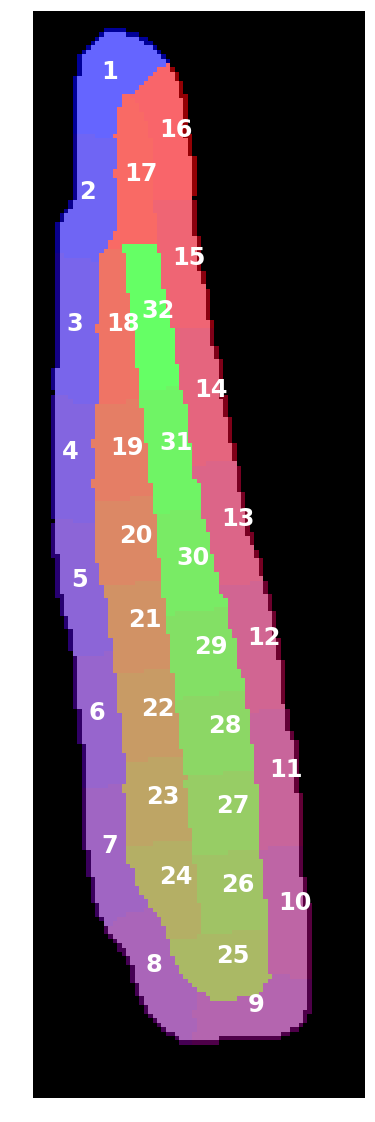

In [80]:
if testing:
    fig, ax = plt.subplots(figsize=[15,20],nrows=1, ncols=1)
    ax.imshow(label_ROIs, cmap=newcmp)

    cent_coord = np.zeros((nregions,2))

    for j in range(nregions):
    #     a = np.zeros_like(label_ROIs).astype(bool)
    #     a[ROIs_means==j+1] = True
        cent_coord[j,:] = np.rint(get_centroid(ROIs_masks[j,:,:]))
        ax.annotate(j+1,(cent_coord[j,0]-2,cent_coord[j,1]),xycoords='data',color='white',fontsize=24,weight='bold')
    ax.axis('off')
    ax.imshow(mask,cmap='gray',alpha=0.4)



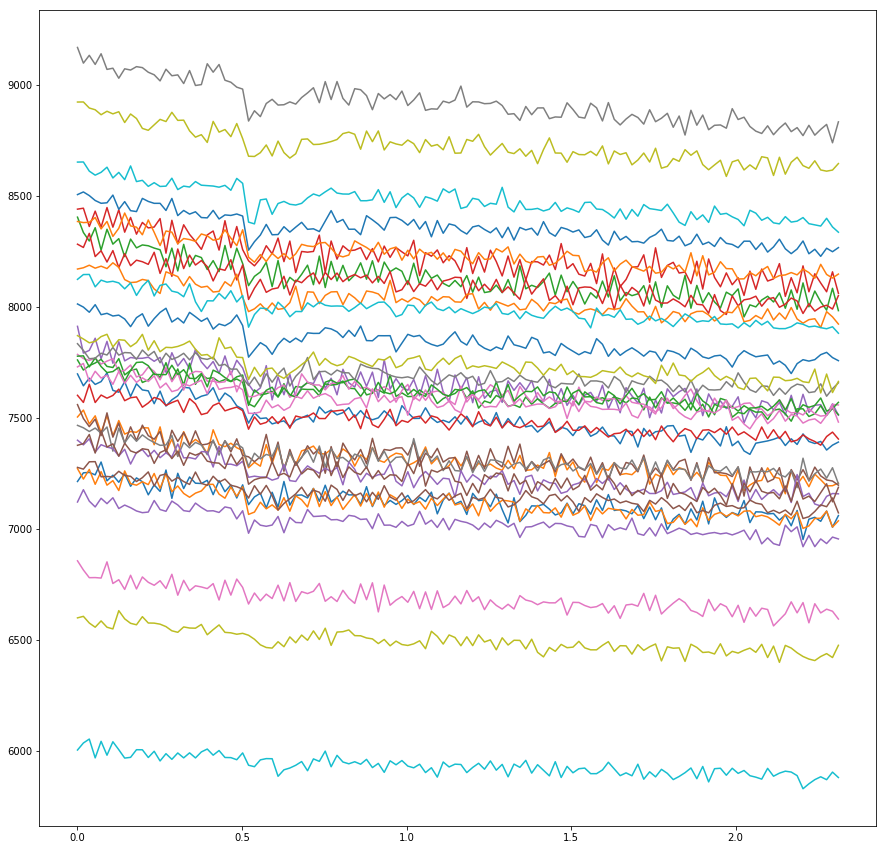

In [81]:
if testing:
#     import matplotlib.gridspec as gridspec

    fig, ax1 = plt.subplots(figsize=[15,15])
#     gs = gridspec.GridSpec(2, 2)
#     ax1 = fig.add_subplot(gs[0, 0])
#     ax2 = fig.add_subplot(gs[0, 1])
#     ax3 = fig.add_subplot(gs[1, :])


    for i in range(32):

        ax1.plot(time,ROIs_means[:,i])

#         ax2.plot(time[1],ROIs_means[1][:,i])

#         ax3.plot(time[2],ROIs_means[2][:,i])


In [ ]:
# def guess_t_sig_prop(video,time,mask):
#     '''Tries to find where signal starts and its duration by cell mask mean over time'''
#     from scipy.signal import detrend
#     video_masked = video*mask
#     video_masked_mean = np.mean(video_masked,axis=(1,2))
    
#     video_masked_mean_detrend = detrend(video_masked_mean,type='linear')
    
#     t_sig_onset, t_sig_onset_idx = guess_t_sig_onset(video_masked_mean_detrend,time)
    
#     t_sig_end,t_sig_end_idx = guess_t_sig_duration(video_masked_mean_detrend, time, t_sig_onset_idx)
#     return(t_sig_onset, t_sig_end)
    
   

In [ ]:
# def guess_t_sig_duration(vmean, time, t_sig_onset_idx):
#     '''Returns indices of time vector later then t_sig_onset and when they are bigger than channel background noise'''
#     noise_threshold = 2*np.std(vmean[:t_sig_onset_idx])
#     plt.plot(time,abs(vmean))
#     plt.plot(time,np.repeat(noise_threshold,len(time)),'b')
#     t_sig_active = np.empty_like(vmean,dtype=bool)
# #     for i in range(len(noise_threshold)):
#     t_sig_active = np.where(abs(vmean)>noise_threshold,True,False)
#     t_sig_active[:t_sig_onset_idx] = False
#     i=t_sig_onset_idx
#     print(t_sig_active)
#     print('i0=',i)
#     if t_sig_active[i]==False:
#         t_sig_active[i]==True
#     while(t_sig_active[i]==True):
#         i+=1
#     print('i=',i)
#     t_sig_end_idx = i
#     return(time[t_sig_end_idx],t_sig_end_idx)
    

In [ ]:
# def guess_t_sig_onset(vmean,time):
#     '''Returns time and correspondig index where absolute maximum derivative is found, indicating signal rise/fall time'''
#     d_vmean = abs(np.diff(vmean))
# #     plt.plot(time[:-1],dROIs_means_corrected)
#     dmax_idx = np.argmax(d_vmean)
# #     if len(ROIs_means_corrected.shape)==2:
# #         mode = np.argmax(np.bincount(dmax_idx))
# #     else:
# #         mode = dmax_idx

        
# #     print(dmax_idx)
    
# #     print(mode)
#     t_sig_onset = time[dmax_idx]  
# #     print(t_sig_onset)
#     return(t_sig_onset, dmax_idx)

In [ ]:
# if testing:
#     t_sig_onset,t_sig_end = guess_t_sig_prop(video, time, mask)
#     print(t_sig_onset,t_sig_end)